In [24]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

In [355]:
amazon_df = pd.read_csv(r"/Users/iqrabismi/Desktop/amazon_close (1).csv")

In [356]:
amazon_df.head(5)

,date,close
0,2019-02-08,1588.22
1,2019-02-07,1614.37
2,2019-02-06,1640.26
3,2019-02-05,1658.81
4,2019-02-04,1633.31


###  EDA and Data Preprocessing

In [357]:
len(amazon_df)

1259

In [358]:
amazon_df.isna().sum()

date     0
close    0
dtype: int64

In [359]:
len(amazon_df[amazon_df.duplicated()]==True)

0

In [360]:
amazon_df.dtypes

date      object
close    float64
dtype: object

In [361]:
## changing data to datetime 

In [362]:
amazon_df['date'] = pd.to_datetime(amazon_df['date'])

In [363]:
### finding the start and end date

In [364]:
amazon_df.date.min(), amazon_df.date.max()

(Timestamp('2014-02-10 00:00:00'), Timestamp('2019-02-08 00:00:00'))

In [365]:
amazon_df.describe()

,close
count,1259.000000
mean,849.730116
std,486.737426
min,286.950000
25%,425.740000
50%,752.610000
75%,1121.915000
max,2039.510000


In [366]:
amazon_df.set_index('date',inplace=True)

<AxesSubplot:>

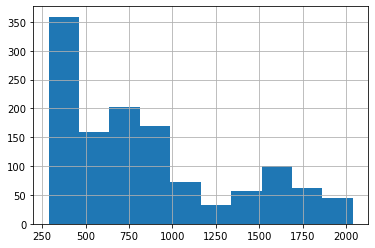

In [367]:
amazon_df.close.hist() # data is right skewed 

<AxesSubplot:xlabel='date'>

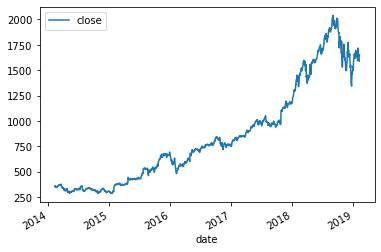

In [368]:
amazon_df.plot(kind='line')

##### To implement ARIMA Model data has to be stationary and from the graph above we can see that data is not stationary. Also, variance and auto correlation should be constant

### Checking data is stationary or not via Dicky-Fuller Test

In [369]:
# Null hypothesis is time series is non-stationary

In [370]:
from statsmodels.tsa.stattools import adfuller
results = adfuller(amazon_df['close'])

In [371]:
results

(-1.3446690965326056,
 0.6084966311408377,
 23,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 10782.877783880944)

p-value is 0.6 which is greater than significant value i.e. 0.5. Hence, we cannot reject null hypothesis. 

#### Making the timeseries stationary 

In [372]:
amazon_df_stationary= amazon_df.diff()

In [373]:
amazon_df_stationary.dropna(inplace=True)

<AxesSubplot:xlabel='date'>

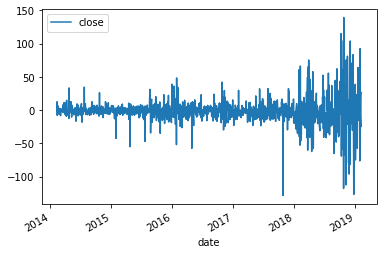

In [374]:
amazon_df_stationary.plot(kind='line')

In [375]:
### implementing the Dicky-Fuller Test

results = adfuller(amazon_df_stationary['close'])

In [376]:
results

(-7.2035794888112425,
 2.331271725487213e-10,
 23,
 1234,
 {'1%': -3.435660336370594,
  '5%': -2.863885022214541,
  '10%': -2.568018522153254},
 10764.626718933836)

Here, p value is less than 0.05. Hence, we can reject the null hypothesis and data is stationary.

### Finding the order of differencing using ADFuller Test. 
Null Hypothesis: data is stationary

In [377]:
adf = adfuller(amazon_df_stationary.iloc[:,0])
print('ADF Statistic:', adf[0])
print('p-value:', adf[1]) ## Hence data is not yet stationary, we need to differentiate further

ADF Statistic: -7.2035794888112425
p-value: 2.331271725487213e-10


### Implementing the ARIMA Models 

ARIMA (AutoRegressive Integrated Moving Average) is a statistical model that can be used for time series forecasting. The "ARIMA" part of the name refers to the three components of the model: the autoregression (AR) component, the differencing (I) component, and the moving average (MA) component.

The order of an ARIMA model refers to the number of lags included in the autoregression and moving average components of the model, and the number of times the data has been differenced. The order of an ARIMA model is denoted by the notation (p,d,q), where p is the order of the autoregression component, d is the order of the differencing component, and q is the order of the moving average component.

One way to determine the order of an ARIMA model is by using the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots of the time series data.

The ACF plot shows the correlation between a time series and lagged versions of itself, whereas the PACF plot shows the correlation between a time series and lagged versions of itself that are not explained by the previous lags.

If the ACF plot decays gradually and the PACF plot cuts off after a few lags, it suggests that the time series data is best modeled with an MA(q) component.

If the PACF plot decays gradually and the ACF plot cuts off after a few lags, it suggests that the time series data is best modeled with an AR(p) component.

If the ACF and PACF plots both decay gradually, it suggests that the time series data is best modeled with an ARIMA(p,d,q) component, where d is the number of times the data has been differenced to make it stationary.

In [393]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


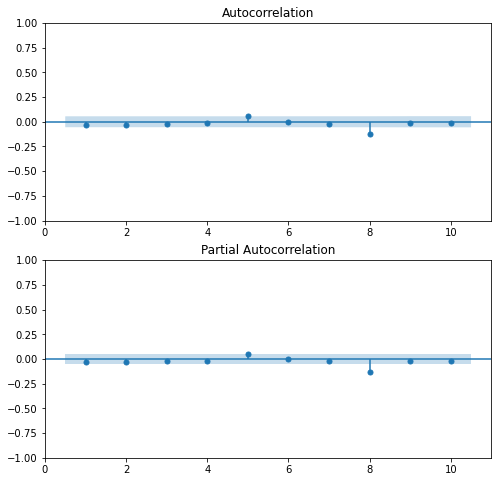

In [394]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(amazon_df_stationary.close, lags=10, zero=False, ax=ax1)
plot_pacf(amazon_df_stationary.close, lags=10, zero=False, ax=ax2)
plt.show()

##### In the above graph both ACF and PACF tails off so its ARMA 

#### Finding the order for ARMA Model

AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are two statistical measures that can be used to compare different models and determine which one is the best fit for a given dataset.

Both AIC and BIC are based on the likelihood of the data given the model, but they also take into account the complexity of the model. AIC rewards models with a higher likelihood but punishes them for having more parameters, while BIC rewards models with a higher likelihood but also punishes them more severely for having more parameters.

The difference between these two metrics is how much they penalize model complexity. The BIC penalizes additional model orders more than AIC and so the BIC will sometimes suggest a simpler model. The AIC and BIC will often choose the same model, but when they don't we will have to make a choice. If our goal is to identify good predictive models, we should use AIC. However if our goal is to identify a good explanatory model, we should use BIC.

In [395]:
from statsmodels.tsa.arima.model import ARIMA


In [396]:
order_aic_bic =[]
# Loop over AR order
for p in range(3):
# Loop over MA order
    for q in range(3):
        # Fit model
        model = ARIMA(amazon_df_stationary.close, order=(p,0,q)) 
        results = model.fit()
        # Add order and scores to list
        order_aic_bic.append((p, q, results.aic, results.bic))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-

In [397]:
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

In [398]:
order_df

,p,q,aic,bic
0,0,0,11080.785682,11091.060239
1,0,1,11081.643124,11097.054959
2,0,2,11082.352218,11102.901332
3,1,0,11081.715536,11097.127371
4,1,1,11080.350474,11100.899588
5,1,2,11082.347404,11108.033797
6,2,0,11082.475149,11103.024263
7,2,1,11082.347455,11108.033848
8,2,2,11076.742691,11107.566362


In [399]:
# Sort by AIC
print(order_df.sort_values('aic'))

   p  q           aic           bic
8  2  2  11076.742691  11107.566362
4  1  1  11080.350474  11100.899588
0  0  0  11080.785682  11091.060239
1  0  1  11081.643124  11097.054959
3  1  0  11081.715536  11097.127371
5  1  2  11082.347404  11108.033797
7  2  1  11082.347455  11108.033848
2  0  2  11082.352218  11102.901332
6  2  0  11082.475149  11103.024263


In [400]:
# Sort by BIC
print(order_df.sort_values('bic'))

   p  q           aic           bic
0  0  0  11080.785682  11091.060239
1  0  1  11081.643124  11097.054959
3  1  0  11081.715536  11097.127371
4  1  1  11080.350474  11100.899588
2  0  2  11082.352218  11102.901332
6  2  0  11082.475149  11103.024263
8  2  2  11076.742691  11107.566362
5  1  2  11082.347404  11108.033797
7  2  1  11082.347455  11108.033848


##### Hence AIC score is lowest for order 2,2 whereas BIC score is lowest for order 0,0. In this project, aim is find a good prediction model for stock prices. Hence, I will consider AIC score. So order is 2,2

### Model Diagnostic

In [401]:
model = ARIMA(amazon_df_stationary.close, order=(2,0,2))
results = model.fit()
# Assign residuals to variable
residuals = results.resid

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-

In [402]:
print(residuals)

date
2019-02-07    27.137300
2019-02-06    27.433353
2019-02-05    21.204955
2019-02-04   -22.674954
2019-02-01    -4.604543
                ...    
2014-02-14     4.408200
2014-02-13     1.466537
2014-02-12    -7.029540
2014-02-11    13.987150
2014-02-10    -0.167099
Length: 1258, dtype: float64


In [403]:
mae = np.mean(np.abs(residuals))

In [404]:
print("mean absolute error is ",mae)

mean absolute error is  11.258990367850423


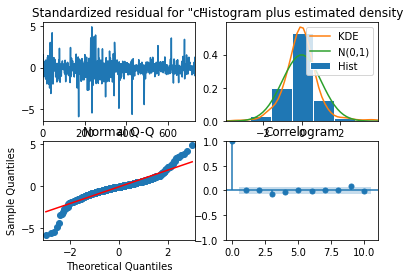

In [446]:
results.plot_diagnostics()
plt.show()

In [406]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5532.371
Date:                Thu, 26 Jan 2023   AIC                          11076.743
Time:                        00:08:12   BIC                          11107.566
Sample:                             0   HQIC                         11088.327
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9873      0.459     -2.151      0.031      -1.887      -0.088
ar.L1         -0.1542      0.078     -1.988      0.047      -0.306      -0.002
ar.L2          0.7944      0.080      9.960      0.0

Prob(Q) - p-value for null hypothesis that residuals are uncorrelated. 
Prob(JB) - p-value for null hypothesis that residuals are normal. 

So, we can see that Prob(Q) value is more than 0.05 so residuals are uncorrelated but p-value for Prob(JB) is less than 0.05 which tells us that residuals are not normally distributed. This may be due to seasonality in the data. For which I will implement SARIMAX model to evaluate the performance of the model. 

### SARIMAX Model

<AxesSubplot:xlabel='date'>

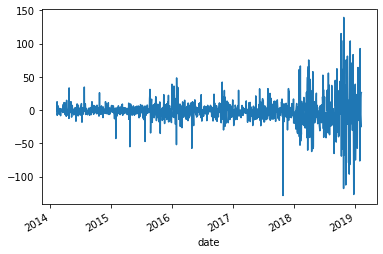

In [407]:
amazon_df_stationary.close.plot(kind='line')

In [408]:
# Import
from statsmodels.tsa.seasonal import seasonal_decompose

In [409]:
decomp_results = seasonal_decompose(amazon_df_stationary.close, period=12)

In [410]:
type(decomp_results)

statsmodels.tsa.seasonal.DecomposeResult

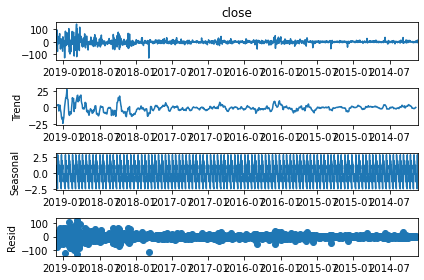

In [411]:
decomp_results.plot()
plt.show()

In [412]:
# Subtract long rolling average over N steps
df = amazon_df_stationary - amazon_df_stationary.rolling(12).mean()
# Drop NaN values
df = amazon_df_stationary.dropna()

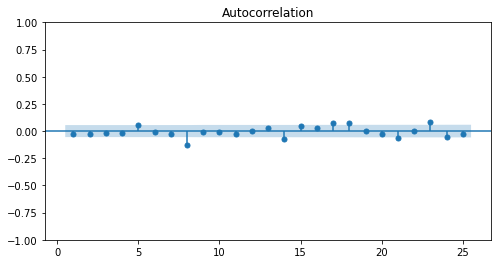

In [413]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(8,4))
# Plot ACF
plot_acf(df.close.dropna(), ax=ax, lags=25, zero=False)
plt.show()

In [414]:
## seasonal differencing 
df_diff = df.diff(12)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


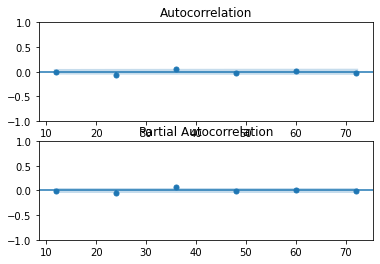

In [415]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(df.close, lags=[12,24,36,48,60,72], ax=ax1)
# Plot seasonal PACF
plot_pacf(df.close, lags=[12,24,36,48,60,72], ax=ax2)
plt.show()

In [416]:
### Searching for order of the model

import pmdarima as pm

In [417]:
results = pm.auto_arima(df.close,d=0, start_p = 0, start_q= 0 , max_p = 4, max_q= 4, 
                       seasonal=True,m=12,D=1, start_P= 1, start_Q= 1, max_P= 4, max_Q=4,
                       information_criterion= 'aic', trace= True, stepwise= True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11823.941, Time=0.13 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11523.474, Time=1.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11821.944, Time=0.16 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11824.926, Time=0.31 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11309.694, Time=4.16 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=11247.154, Time=8.08 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=11179.925, Time=15.33 sec
 ARIMA(1,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=32.30 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=15.93 sec
 ARIMA(0,0,0)(4,1,0)[12] intercept   : AIC=11178.555, Time=29.31 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=11245.494, Time=34.85 sec
 ARIMA(0,0,0)(4,1,1)[12] intercept   : AIC=inf, Time=17.87 sec
 ARIMA(0,0,0)(3,1,1)[12] inte

In [418]:
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                 1258
Model:             SARIMAX(4, 1, 0, 12)   Log Likelihood               -5583.277
Date:                  Thu, 26 Jan 2023   AIC                          11176.555
Time:                          00:12:45   BIC                          11202.193
Sample:                               0   HQIC                         11186.194
                                 - 1258                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8136      0.013    -63.841      0.000      -0.839      -0.789
ar.S.L24      -0.7007      0.018    -38.453      0.000      -0.736      -0.665
ar.S.L36      -0.4202      0.019    

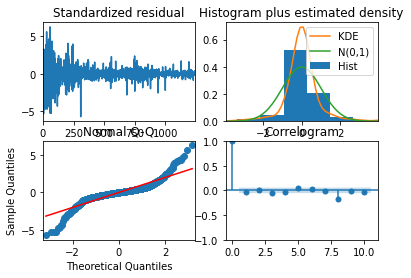

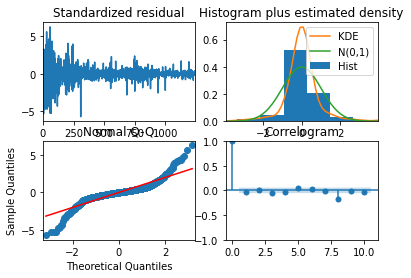

In [419]:
results.plot_diagnostics()

## Predictions 

In [420]:
### Train-test split

df_train = df.loc[:'2017']
# Test data - all data from 2019 onwards
df_test = df.loc['2017':]

/var/folders/fg/0cvyhxdj5v7503hv35z31yhr0000gn/T/ipykernel_93588/1755962535.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_test = df.loc['2017':]


In [421]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [422]:
model = SARIMAX(df_train, order=(0,0,0), seasonal_order=(4,0,1,12))

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [423]:
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69637D+00    |proj g|=  1.60777D-02

At iterate    5    f=  3.69570D+00    |proj g|=  1.40531D-02

At iterate   10    f=  3.69523D+00    |proj g|=  1.09220D-04

At iterate   15    f=  3.69522D+00    |proj g|=  1.36143D-03

At iterate   20    f=  3.69503D+00    |proj g|=  4.36186D-03

At iterate   25    f=  3.69471D+00    |proj g|=  4.66472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     38      1     0     0   

In [424]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      close   No. Observations:                  730
Model:             SARIMAX(4, 0, [1], 12)   Log Likelihood               -2697.137
Date:                    Thu, 26 Jan 2023   AIC                           5406.274
Time:                            00:12:51   BIC                           5433.832
Sample:                                 0   HQIC                          5416.906
                                    - 730                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.6152      0.406      1.517      0.129      -0.180       1.410
ar.S.L24       0.0819      0.047      1.732      0.083      -0.011       0.174
ar.S.L36      -0.0088      0.055     -0.160      0.873      -0.116       0.099
ar.S.L48      -0.0489      0.039     -1.257      0.209      -0.125       0.027
ma.S.L12      -0.6708      0.400     -1.676      0.094      -1.455       0.114
sigma2        94.7523      2.394     39.585      0.000      90.061      99.444
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              1522.72
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

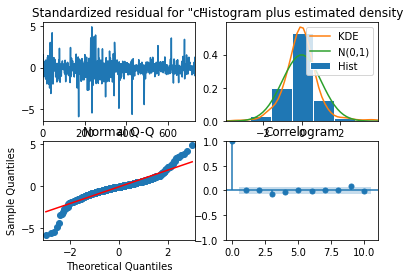

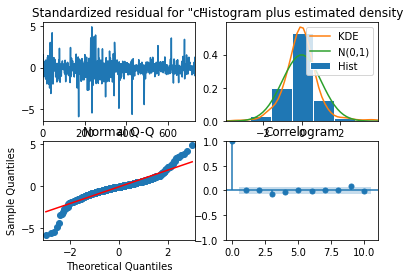

In [425]:
results.plot_diagnostics()

### Prediction using the training data to evaluate the performance

In [426]:
forecast = results.get_prediction(start=-20)

In [427]:
mean_forecast = forecast.predicted_mean

In [428]:
mean_forecast= pd.DataFrame(mean_forecast)

In [429]:
confidence_intervals = forecast.conf_int()

In [430]:
confidence_intervals.head(5)

,lower close,upper close
date,,
2014-03-10,-19.221522,18.935369
2014-03-07,-19.689833,18.467058
2014-03-06,-18.688276,19.468616
2014-03-05,-19.825967,18.330924
2014-03-04,-19.202115,18.954777


In [431]:
df_train1= df_train.loc['2014']

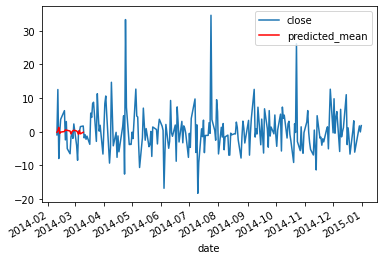

In [432]:
fig,ax= plt.subplots()
# Plot prediction
df_train1.plot(kind='line', ax= ax)
mean_forecast.plot(color='red',label='forecast', ax= ax)
# Shade uncertainty area
#plt.fill_between(x= 'date', 'lower_limits,', upper_limits, color='pink')
plt.show()

### Forecasting

In [434]:
forecast = results.get_forecast(steps=20)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [435]:
# forecast mean
mean_forecast = forecast.predicted_mean

In [436]:
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()

In [437]:
mean_forecast= pd.DataFrame(mean_forecast)

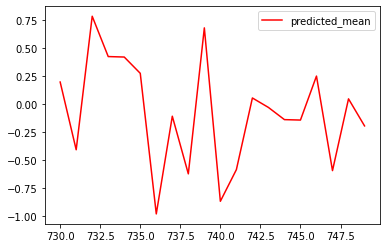

In [438]:
fig,ax= plt.subplots()
# Plot prediction
mean_forecast.plot(color='red',label='forecast', ax= ax)
# Shade uncertainty area
#plt.fill_between(x= 'date', 'lower_limits,', upper_limits, color='pink')
plt.show()

### Reconstructing the Time Series

In [439]:
diff_forecast = results.get_forecast(steps=20).predicted_mean
from numpy import cumsum
mean_forecast = cumsum(diff_forecast) + df_test.iloc[-1,0]

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [440]:
mean_forecast

730   -14.990652
731   -15.397300
732   -14.609284
733   -14.182047
734   -13.759034
735   -13.481717
736   -14.462461
737   -14.568932
738   -15.191216
739   -14.507217
740   -15.374993
741   -15.959581
742   -15.902889
743   -15.930818
744   -16.067873
745   -16.208818
746   -15.956176
747   -16.549484
748   -16.500644
749   -16.693788
Name: predicted_mean, dtype: float64